## Deep Research Experiment with `LangGraph`

This notebook aims to test multi-round research with back-and-forth between an OpenAI LLM and Perplexity. Orchestrated with `LangGraph`.



In [1]:
import os
from datetime import datetime

from dotenv import load_dotenv
load_dotenv()

from IPython.display import display, Markdown, Image
from langchain_core.messages import BaseMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.constants import Send
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph.message import add_messages
import operator

from pydantic import BaseModel, Field
from typing import Annotated, Sequence, TypedDict, List, Dict

import pandas as pd

### Prompts

In [2]:
system_message_content = """You are a helpful assistant that can help with research."""
system_message = SystemMessage(content=system_message_content)

### research question writer

user_message_template = """
A user requires help with their research question. They have provided a topic they are interested in and the reason for their interest. Additionally, they have provided some background on themselves to help you understand their perspective.

<topic>
{topic}
</topic>

<reason>
{reason}
</reason>

<background>
{background}
</background>


Your task is to write research questions that can be submitted to Perplexity or Google Scholar for further research. Return a list of research questions.
"""

### answer writer prompt

answer_writer_template = """
You are assisting a user with their research. The topic is:

<topic>
{topic}
</topic>

The question you need to answer is:
<question>
{question}
</question>

Provide a detailed answer to the question.
"""

### research summarizer

research_summarizer_template = """
You are assisting a user with their research. The user has provided a research topic, for which questions have been already generated and answered. You will be provided with this list of questions and answers. Your task is to summarize the research in a professional way.

<topic>
{topic}
</topic>

<reason>
{reason}
</reason>

<background>
{background}
</background>

<questions and answers>
{questions_with_answers}
</questions and answers>

Provide the professional summary of the research.
"""

### further research validator

further_research_validator_template = """
You are assisting a user with their research. The user has provided a research topic, for which a research summary has been produced. Your task is to decide if, given the user's background and reason for interest, the summary is accurate and complete or any further deep dive is needed.

<topic>
{topic}
</topic>

<reason>
{reason}
</reason>

<background>
{background}
</background>

<research summary>
{research_summary}
</research summary>

Return with the decision if further questions are needed, a reason for the decision and if the decision is to go deeper, generate the next round of questions.
"""


### Structured Outputs

In [3]:
class ResearchQuestion(BaseModel):
    question: str = Field(description="A research question that can be submitted to Perplexity or Google Scholar for further research.")

class ResearchQuestions(BaseModel):
    questions: List[ResearchQuestion] = Field(description="A list of research questions that can be submitted to Perplexity or Google Scholar for further research.")

class FurtherResearchValidator(BaseModel):
    decision: bool = Field(description="A decision if further questions are needed (True) or not (False).")
    reason: str = Field(description="The reason for the decision.")
    questions: List[ResearchQuestion] = Field(description="A list of research questions that can be submitted to Perplexity or Google Scholar for further research.")


### LLMs

In [4]:
question_writer_model = "gpt-4o-2024-11-20"
further_research_validator_model = "gpt-4o-2024-11-20"
research_summarizer_model = "gpt-4o-2024-11-20"

question_writer_llm = ChatOpenAI(
    model=question_writer_model, 
    temperature=0.0
    )
question_writer_llm = question_writer_llm.with_structured_output(ResearchQuestions, method="json_schema", include_raw=True)

answer_writer_model = "llama-3.1-sonar-large-128k-online"
answer_writer_llm = ChatOpenAI(
    model=answer_writer_model, 
    temperature=0.0, 
    base_url="https://api.perplexity.ai", 
    api_key=os.getenv('PPLX_API_KEY')
    )

further_research_validator_llm = ChatOpenAI(
    model=further_research_validator_model, 
    temperature=0.0
    )
further_research_validator_llm = further_research_validator_llm.with_structured_output(FurtherResearchValidator, method="json_schema", include_raw=True)

research_summarizer_llm = ChatOpenAI(
    model=research_summarizer_model, 
    temperature=0.0
    )

### Build the graph

In [5]:
class AgentState(TypedDict):

    topic: str
    reason: str
    background: str

    messages: Annotated[Sequence[BaseMessage], add_messages]

    questions: List[str]
    question: str
    questions_with_answers: Annotated[List[Dict[str, str]], operator.add]

    further_research_rounds: int
    further_research_needed: bool

    research_summary: str

In [6]:
def write_questions(state: AgentState) -> AgentState:

    user_message = user_message_template.format(
        topic=state['topic'], 
        reason=state['reason'], 
        background=state['background']
        )
    
    response = question_writer_llm.invoke([system_message] + [user_message])

    response_parsed = response["parsed"]
    response_raw = response["raw"]
    response_raw.name = 'Question Writer'
    
    questions = [question.question for question in response_parsed.questions]
    
    return {
        'questions': questions,
        'messages': [system_message] + [user_message] + [response_raw]
        }

def answer_question(state: AgentState) -> AgentState:

    print(f'Answering question: {state["question"]}\n')

    user_message = answer_writer_template.format(
        topic=state['topic'], 
        question=state['question']
        )
    
    response = answer_writer_llm.invoke([system_message] + [user_message])
    response.name = 'Answer Writer'

    return {
        'messages': [response],
        'questions_with_answers': [{'question': state['question'], 'answer': response.content}]
        }

def send_questions_to_answer_writer(state: AgentState) -> AgentState:

    return [Send("answer_question", {"question": q, "topic": state['topic']}) for q in state['questions']]

def summarize_research(state: AgentState) -> AgentState:

    print('Summarizing research')

    user_message = research_summarizer_template.format(
        topic=state['topic'], 
        reason=state['reason'], 
        background=state['background'], 
        questions_with_answers=state['questions_with_answers']
        )
    
    response = research_summarizer_llm.invoke([system_message] + [user_message])
    response.name = 'Research Summarizer'

    return {
        'research_summary': response.content,
        'messages': [response]
        }


def validate_further_research(state: AgentState) -> AgentState:

    rounds_remaining = state['further_research_rounds']

    if rounds_remaining == 0:

        print('No further research rounds left.')

        return {
            'further_research_needed': False,
        }

    user_message = further_research_validator_template.format(
        topic=state['topic'], 
        reason=state['reason'], 
        background=state['background'], 
        research_summary=state['research_summary']
        )
    
    response = further_research_validator_llm.invoke([system_message] + [user_message])
    response_raw = response['raw']
    response_raw.name = 'Further Research Validator'

    if response['parsed'].decision:

        print(f'Further research needed. {rounds_remaining} rounds remaining max.')
        print(f'Reason: {response["parsed"].reason}')

        questions = [question.question for question in response['parsed'].questions]
    
        return {
            'further_research_rounds': rounds_remaining - 1,
            'further_research_needed': True,
            'questions': questions, # overwrite questions with new questions
            'messages': [response_raw]
            }
    
    else:

        print('No further research needed.')
        print(f'Reason: {response["parsed"].reason}')
        return {
            'further_research_needed': False,
            'messages': [response_raw]
            }
    
def route_from_validation(state: AgentState):
    if state['further_research_needed']:
        return "go_deeper"
    else:
        return "end"
    
def get_new_questions(state: AgentState) -> AgentState:
    pass

In [7]:
workflow = StateGraph(AgentState)

workflow.add_node("write_questions", write_questions)
workflow.add_node("answer_question", answer_question)
workflow.add_node("summarize_research", summarize_research)
workflow.add_node("validate_further_research", validate_further_research)
workflow.add_node("get_new_questions", get_new_questions)

workflow.add_edge(START, "write_questions")
workflow.add_conditional_edges("write_questions", send_questions_to_answer_writer, ["answer_question"])
workflow.add_edge("answer_question", "summarize_research")
workflow.add_edge("summarize_research", "validate_further_research")

workflow.add_conditional_edges("validate_further_research", route_from_validation, {"end": END, "go_deeper": "get_new_questions"})
workflow.add_conditional_edges("get_new_questions", send_questions_to_answer_writer, ["answer_question"])


app = workflow.compile()

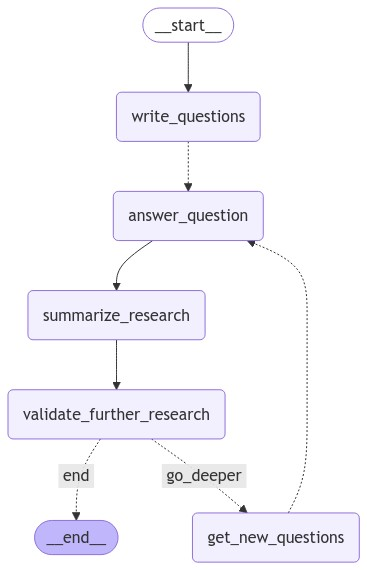

In [10]:
graph_image = app.get_graph().draw_mermaid_png()
with open("../output/research_experiment/langgraph.png", "wb") as f:
    f.write(graph_image)
display(Image(graph_image))

### Testing scenarios

In [9]:
scenarios = [
    {
        "topic": "The GOAT of the NFL",
        "reason": "I want to know who is the GOAT of the NFL. I have an ongoing debate with a friend between Tom Brady and Patrick Mahomes.",
        "background": "I am a football fan and I have been watching the NFL for 20 years.",
        "further_research_rounds": 3,
        "further_research_needed": True
    },
    {
        "topic": "Do I invest in Bitcoin?",
        "reason": "I want to know if I should invest in Bitcoin. I have been following the news and the price has been going up since Trump's re-election.",
        "background": "I don't invest in crypto, I have some stocks and ETFs",
        "further_research_rounds": 3,
        "further_research_needed": True
    },
    {
        "topic": "Should I buy a 2yo used Tesla Model 3?",
        "reason": "I'm looking to own my first EV",
        "background": "I have never owned an EV before, if I do end up buying one, I want a Tesla",
        "further_research_rounds": 3,
        "further_research_needed": True
    }
]


In [10]:
scenarios_results = []

for scenario in scenarios:

    print(f'Running scenario: {scenario["topic"]}')

    test = app.invoke(scenario)
    scenarios_results.append(test)
    
    print('*' * 30)

Running scenario: The GOAT of the NFL
Answering question: Who is considered the greatest NFL player of all time (GOAT) and why?
Answering question: What are the career achievements and statistics of Tom Brady and Patrick Mahomes?


Answering question: How do experts and analysts compare Tom Brady and Patrick Mahomes in terms of their impact on the NFL?

Answering question: What criteria are commonly used to determine the GOAT in the NFL?

Answering question: What are the arguments for and against Tom Brady being the GOAT of the NFL?

Answering question: What are the arguments for and against Patrick Mahomes being the GOAT of the NFL?

Summarizing research
Further research needed. 3 rounds remaining max.
Reason: The research summary provides a comprehensive overview of the GOAT debate between Tom Brady and Patrick Mahomes, but given the user's background as a long-time NFL fan and their interest in debating this topic with a friend, they might benefit from more detailed and specific com

In [14]:
for scenario in scenarios_results:
    
    # Format datetime
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create filename - replace spaces and special chars with underscores
    filename = f"../output/research_experiment/{scenario['topic'].replace(' ', '_').replace('?', '').replace('!', '')}_{timestamp}.md"
    
    # Write to file
    with open(filename, 'w') as f:
        f.write(scenario["research_summary"])
    
    # Still display in notebook
    display(Markdown(scenario["research_summary"]))
    print('\n' * 2)

### Professional Summary: The GOAT of the NFL

The debate over the Greatest of All Time (GOAT) in the NFL is a complex and multifaceted discussion, with Tom Brady and Patrick Mahomes emerging as the two primary candidates. This research explores their respective careers, achievements, and contributions to the sport, while also considering broader criteria for evaluating greatness in the NFL.

#### **Tom Brady: The Current GOAT**
Tom Brady is widely regarded as the GOAT due to his unparalleled career achievements, longevity, and consistent excellence. Over 23 seasons, Brady accumulated an unmatched record of seven Super Bowl victories, five Super Bowl MVPs, and three NFL MVP awards. He holds numerous NFL records, including career passing yards (89,214), passing touchdowns (649), and playoff wins (35). His ability to perform under pressure is legendary, with 44 fourth-quarter comebacks and iconic performances such as the comeback in Super Bowl LI and the "Tuck Rule Game." Brady's longevity and adaptability, including leading the Tampa Bay Buccaneers to a Super Bowl win in his first season with the team, further solidify his GOAT status. Analysts and players alike recognize his leadership, consistency, and impact on the sport as defining traits of his greatness.

#### **Patrick Mahomes: The Rising Challenger**
Patrick Mahomes, despite being early in his career, has already built a compelling case as a future GOAT contender. In just seven seasons, Mahomes has won three Super Bowls, earned three Super Bowl MVPs, and captured two NFL MVP awards. Known for his exceptional talent, creativity, and ability to perform under pressure, Mahomes has set numerous records, including the fastest to reach 10,000 and 30,000 passing yards. His playoff performances, such as leading the Kansas City Chiefs back from a 24-point deficit against the Texans in the 2019 Divisional Round, highlight his resilience and clutch ability. Statistically, Mahomes surpasses Brady in several rate metrics, including completion percentage (66.5%), yards per attempt (7.9), and passer rating (103.5). While Mahomes has yet to match Brady's longevity and total accolades, his early success and potential for sustained dominance make him a strong challenger.

#### **Criteria for Evaluating the GOAT**
NFL analysts and historians use several criteria to evaluate the GOAT, including team accomplishments, individual accolades, personal statistics, longevity, consistency, situational performance, and impact on the sport. Brady excels in longevity, championships, and consistency, while Mahomes stands out for his early dominance, efficiency, and dynamic play. Era differences, such as rule changes favoring offense and advancements in training, also influence comparisons between players.

#### **Head-to-Head Comparisons**
Brady and Mahomes have faced each other six times, with the head-to-head record tied at 3-3. Mahomes leads in regular-season matchups (3-1), while Brady has the edge in playoff games (2-0), including a victory in Super Bowl LV. These encounters highlight their respective strengths, with Brady's experience and leadership prevailing in high-stakes games and Mahomes' explosiveness shining in regular-season contests.

#### **Broader GOAT Debate**
While Brady and Mahomes dominate the GOAT conversation, other players such as Joe Montana, Peyton Manning, and Dan Marino are occasionally mentioned. Montana's four Super Bowl wins, Manning's seven MVP awards, and Marino's statistical dominance in his era contribute to their inclusion in the discussion. However, Brady's longevity and Mahomes' early success set them apart as the primary contenders.

#### **Conclusion**
Tom Brady's extensive career achievements, unmatched consistency, and leadership currently establish him as the GOAT of the NFL. However, Patrick Mahomes' rapid rise, exceptional talent, and potential for long-term dominance position him as a formidable challenger. The GOAT debate ultimately reflects differing perspectives on greatness, whether it is defined by sustained excellence over decades or explosive dominance within a shorter timeframe. As Mahomes' career progresses, the debate will continue to evolve, enriching the narrative of what it means to be the greatest in NFL history.

### Research Summary: Should I Invest in Bitcoin?

#### Overview
The research explores the viability of investing in Bitcoin, particularly in light of its recent price surge following Donald Trump’s re-election. The analysis compares Bitcoin to traditional investments like stocks and ETFs, evaluates its historical performance, examines the factors influencing its price, and considers the regulatory, environmental, and tax implications. The research also assesses the potential benefits and risks of adding Bitcoin to a diversified portfolio and compares direct Bitcoin investment to Bitcoin ETFs.

---

#### Key Findings

1. **Risks and Benefits of Bitcoin Investment**:
   - **Risks**: Bitcoin is highly volatile, with significant price fluctuations over short periods. It faces security risks (e.g., hacking), operates in a largely unregulated environment, and has a substantial environmental impact due to energy-intensive mining. Additionally, its value is influenced by macroeconomic factors, market sentiment, and competition from other cryptocurrencies.
   - **Benefits**: Bitcoin offers portfolio diversification due to its low correlation with traditional assets, potential for high returns, 24/7 liquidity, and independence from central authorities. Bitcoin ETFs provide an alternative for investors seeking exposure to Bitcoin with added security and regulatory oversight.

2. **Historical Performance and Political Events**:
   - Bitcoin has historically reacted positively to major political events, including U.S. presidential elections. For example, following Trump’s 2016 and 2024 victories, Bitcoin experienced significant price surges. The 2024 rally was driven by Trump’s pro-crypto stance, including promises of regulatory clarity and the appointment of crypto-friendly officials.
   - However, the long-term sustainability of such price increases depends on broader economic conditions, regulatory developments, and the fulfillment of campaign promises.

3. **Factors Influencing Bitcoin’s Price**:
   - Bitcoin’s price is driven by supply and demand dynamics, halving events, speculation, regulatory changes, market sentiment, and macroeconomic factors. Technological advancements and competition from other cryptocurrencies also play a role.
   - Political and economic developments, such as Trump’s re-election and pro-crypto policies, have a direct impact on market sentiment and price movements.

4. **Regulatory and Economic Policies Under Trump**:
   - Trump’s administration has proposed several pro-crypto policies, including reversing restrictive regulations, creating a national Bitcoin reserve, and offering tax incentives for U.S.-based crypto businesses. These measures aim to position the U.S. as a global leader in cryptocurrency and could positively influence Bitcoin’s market dynamics.

5. **Environmental Impact**:
   - Bitcoin mining consumes significant energy, contributing to carbon emissions and electronic waste. Efforts to mitigate these impacts include the use of renewable energy, carbon offsetting, and the development of more sustainable blockchain technologies.

6. **Tax Implications**:
   - Bitcoin is treated as property by the IRS, making transactions subject to capital gains tax. Short-term gains are taxed as ordinary income, while long-term gains benefit from lower tax rates. Receiving Bitcoin as income or mining it is also taxable. Accurate record-keeping and compliance with reporting requirements are essential.

7. **Bitcoin ETFs vs. Direct Investment**:
   - **Bitcoin ETFs**: Offer ease of access, regulatory oversight, and security but involve management fees and tracking errors. They are suitable for investors familiar with traditional financial markets.
   - **Direct Bitcoin Investment**: Provides direct ownership and lower costs but requires technical expertise and involves security risks. It is better suited for investors comfortable with cryptocurrency management.

8. **Portfolio Considerations**:
   - Adding Bitcoin to a portfolio can enhance diversification and potentially increase returns. However, its high volatility can significantly impact overall portfolio risk. A small allocation (e.g., 1-5%) is recommended for risk-averse investors.

9. **Expert Predictions**:
   - Analysts predict that Trump’s re-election and pro-crypto policies could drive Bitcoin’s price to new highs, with some estimates reaching $100,000 or more. However, the accuracy of such predictions is limited due to Bitcoin’s inherent volatility and the unpredictability of market dynamics.

---

#### Conclusion
Investing in Bitcoin offers both opportunities and risks. It can serve as a high-risk, high-reward asset that diversifies a portfolio and provides exposure to the growing cryptocurrency market. However, its volatility, regulatory uncertainties, environmental impact, and tax implications require careful consideration. For investors with experience in stocks and ETFs, Bitcoin ETFs may provide a more accessible and secure entry point. Ultimately, the decision to invest in Bitcoin should align with the investor’s financial goals, risk tolerance, and understanding of the cryptocurrency market.

### Research Summary: Should I Buy a 2-Year-Old Used Tesla Model 3?

#### Overview
The research evaluates the feasibility of purchasing a 2-year-old Tesla Model 3 for a first-time electric vehicle (EV) buyer. It examines the advantages, disadvantages, costs, maintenance, battery health, and comparisons with other EVs in the same price range. The analysis also considers factors such as charging infrastructure, insurance costs, and known issues or recalls.

---

### Key Findings

#### **Advantages of Buying a 2-Year-Old Tesla Model 3**
1. **Cost Savings**: A 2-year-old Tesla Model 3 is significantly cheaper than a new one, with prices ranging from $22,000 to $30,000 depending on the model and condition. This represents substantial savings compared to the original price of $40,000–$60,000.
2. **Performance and Features**: Even older models offer excellent performance, with the Performance variant delivering 456 hp and advanced features like Tesla’s Autopilot and over-the-air software updates.
3. **Battery Health**: Tesla batteries degrade slowly, with a 2-year-old Model 3 retaining approximately 85–92% of its original capacity, translating to 80–85% of its original range.
4. **Access to Tesla’s Supercharger Network**: Tesla’s extensive and reliable charging infrastructure is a significant advantage for long-distance travel.
5. **Resale Value**: Tesla vehicles generally retain their value better than many other EVs, making them a strong investment.

---

#### **Disadvantages and Considerations**
1. **Warranty Limitations**: While Tesla’s battery and drivetrain warranty lasts 8 years, the basic warranty (4 years/50,000 miles) may be nearing expiration for a 2-year-old vehicle.
2. **Maintenance Concerns**: Common issues include tire wear, suspension component wear, and occasional software glitches. Maintenance costs are relatively low, averaging $358 annually, but repairs like tire replacements and brake caliper lubrication can add to costs.
3. **Cosmetic and Build Quality Issues**: Some used Model 3s may exhibit minor cosmetic flaws, such as panel gaps or paint imperfections, which are common in earlier production years.
4. **Insurance Costs**: The average annual insurance cost for a 2-year-old Tesla Model 3 is approximately $2,086, which is higher than some other EVs in the same price range.

---

#### **Battery Health and Charging Infrastructure**
- **Battery Health**: Tesla Model 3 batteries degrade at an average rate of 1.8% per year, which is consistent with industry standards. A 2-year-old Model 3 is expected to retain 85–92% of its original capacity, ensuring reliable range performance.
- **Charging Infrastructure**: Tesla’s Supercharger network is a major advantage, offering fast and convenient charging. Home charging via a Level 2 charger costs $1,000–$1,500 for installation, including the charger unit and electrical work.

---

#### **Comparison with Other EVs**
- **Performance**: The Tesla Model 3 outperforms many competitors in acceleration and range, with up to 363 miles of range in the Long Range variant.
- **Price and Insurance**: While the Model 3 is more expensive to insure than EVs like the MINI Electric or Hyundai Ioniq, it offers superior technology, performance, and access to Tesla’s charging network.
- **Technology**: Tesla’s advanced software, Autopilot, and over-the-air updates set it apart from competitors like the Hyundai Ioniq 6 and Ford Mustang Mach-E.

---

#### **Known Issues and Recalls**
- **Recalls**: Recent recalls include issues with the rearview camera, Autopilot system, and tire pressure monitoring system. Tesla has addressed these through over-the-air software updates or free repairs.
- **Common Issues**: Reported problems include suspension wear, tire alignment, and occasional touchscreen malfunctions. These issues are generally manageable and often covered under warranty.

---

### Financial Considerations
1. **Financing Options**: Used Tesla Model 3s can be financed through banks, credit unions, or Tesla’s Certified Pre-Owned program. Monthly payments vary based on credit score, with competitive rates available for buyers with good credit.
2. **Insurance Costs**: While higher than some EVs, Tesla Model 3 insurance costs are competitive within the luxury EV segment. State Farm offers some of the lowest rates for Tesla vehicles.
3. **Total Cost of Ownership**: Over five years, the total cost of ownership for a Tesla Model 3 is estimated at $52,970, including purchase price, maintenance, and insurance.

---

### Recommendations for First-Time EV Buyers
1. **Inspect the Vehicle**: Check for battery health, warranty status, service history, and any outstanding recalls. A test drive is essential to identify potential issues.
2. **Consider Charging Needs**: Ensure access to home charging or nearby public charging stations. Installing a Level 2 home charger is recommended for convenience.
3. **Evaluate Alternatives**: While the Tesla Model 3 offers superior performance and technology, other EVs like the Hyundai Ioniq 6 or Ford Mustang Mach-E may provide better value for buyers prioritizing lower insurance costs or upfront pricing.

---

### Conclusion
A 2-year-old Tesla Model 3 is an excellent choice for a first-time EV buyer seeking a balance of performance, technology, and long-term value. While it comes with some maintenance and insurance considerations, its cost savings, access to Tesla’s Supercharger network, and strong resale value make it a compelling option. Buyers should carefully inspect the vehicle, consider their charging infrastructure needs, and compare financing and insurance options to make an informed decision.

In [15]:
cost_mapper = {
    'gpt-4o-2024-11-20': 
        {'input_tokens' : 2.5/1000000, 'output_tokens' : 10/1000000},
    'llama-3.1-sonar-large-128k-online': 
        {'input_tokens' : 1/1000000, 'output_tokens' : 1/1000000}
}

def calculate_usage(app_result):

    usage_data = []

    for i in app_result['messages']:

        model_name = i.response_metadata if hasattr(i, 'response_metadata') else None
        try:
            model_name = model_name['model_name']
        except:
            model_name = None

        usage_metadata = i.usage_metadata if hasattr(i, 'usage_metadata') else None

        r = {
            "name" : i.name, 
            "model_name" : model_name
            }
        
        if usage_metadata:
            r.update(usage_metadata)
        
        usage_data.append(r)

    usage_df = pd.DataFrame(usage_data)
    usage_df_by_model = usage_df.groupby('model_name').agg({'input_tokens': 'sum', 'output_tokens': 'sum'}).astype(int)

    # Add cost columns
    usage_df_by_model['input_cost'] = usage_df_by_model.apply(lambda row: row['input_tokens'] * cost_mapper[row.name]['input_tokens'], axis=1)
    usage_df_by_model['output_cost'] = usage_df_by_model.apply(lambda row: row['output_tokens'] * cost_mapper[row.name]['output_tokens'], axis=1)
    usage_df_by_model['total_cost'] = usage_df_by_model['input_cost'] + usage_df_by_model['output_cost']

    print(f"Total cost: ${usage_df_by_model['total_cost'].sum():.6f}")

    return usage_df, usage_df_by_model

In [16]:
for scenario in scenarios_results:
    print(f'Scenario: {scenario["topic"]}')
    usage, usage_by_model = calculate_usage(scenario)
    print('\n')

Scenario: The GOAT of the NFL
Total cost: $0.154053


Scenario: Do I invest in Bitcoin?
Total cost: $0.137670


Scenario: Should I buy a 2yo used Tesla Model 3?
Total cost: $0.167957


